# 関数

## DBSCANのeps設定のための描画
- あんまりわかってない

In [5]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.ylim((0,0.2))
    plt.show()
    plt.close()

## CSV読み込み

In [6]:
import csv
def readCSV(file_path, parse_func) -> list[list]:
    data = None
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        data:list[list] = []
        for row in reader:
            row_data = []
            for d in row:
                row_data.append(parse_func(d))
            data.append(row_data)
    
    return data

## クラスタリングの評価
- return accuracy, precision, recall, f1

In [7]:
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix,precision_score,recall_score,f1_score

def acc_est(clustering_result, quiet=False):
    return _est(clustering_result, "./data/note_sims/sim_acc.csv", "./data/note_sims/not_sim_acc.csv", quiet)

def est(clustering_result, quiet=False):
    return _est(clustering_result, "./data/note_sims/sim.csv", "./data/note_sims/not_sim.csv", quiet)

def _est(clustering_result, sim_file_path, nsim_file_path, quiet=False):
    count = len(clustering_result)
    labels = {True: 1, False:0, None:"none"}
    result_table = [[labels[i == j] for j in clustering_result] for i in clustering_result]
    sim_table = [[labels[None] for _ in clustering_result] for _ in clustering_result]
    # _sim_table = [[None for _ in clustering_result] for _ in clustering_result]
    sim_data = readCSV(sim_file_path, int)
    not_sim_data = readCSV(nsim_file_path, int)
    if not sim_data or sim_data is None or len(sim_data) == 0:
        print("load error")
        return
    if not not_sim_data or not_sim_data is None or len(not_sim_data) == 0:
        print("load error")
        return

    for [s,t] in sim_data:
        sim_table[s][t] = labels[True]
        sim_table[t][s] = labels[True]
    for [s,t] in not_sim_data:
        sim_table[s][t] = labels[False]
        sim_table[t][s] = labels[False]

    sims_true = []
    sims = []
    for i in range(count):
        for j in range(i+1,count):
            if sim_table[i][j] == labels[None]:
                continue
            
            sims_true.append(sim_table[i][j])
            sims.append(result_table[i][j])

    confusion_matrix = multilabel_confusion_matrix(sims_true, sims)
    accuracy = accuracy_score(sims_true, sims)
    precision = precision_score(sims_true, sims)
    recall = recall_score(sims_true, sims)
    f1 = f1_score(sims_true, sims)
    
    if not quiet:
        print("\n===== 評価 =====")
        print(np.array([["tp rate", "fn rate"], ["tn rate", "tn rate"]]))
        for label, matrix in zip(labels.values(), confusion_matrix):
            print(f"{label=}")
            sm = sum(sum(matrix))
            print(f"{matrix/sm}")
        print(f"{accuracy=}")
        print(f"{precision=}")
        print(f"{recall=}")
        print(f"{f1=}")
        print("=================\n")
    # print(f"accuracy = {accuracy_score()}")
    return accuracy, precision, recall, f1

# main

['./data/_json/feature_vector/test/song155_[cnt_move_flip2]_fv.json']
eps = 0.02
clusters count: 28

===== 評価 =====
[['tp rate' 'fn rate']
 ['tn rate' 'tn rate']]
label=1
[[0.         0.26388889]
 [0.125      0.61111111]]
label=0
[[0.61111111 0.125     ]
 [0.26388889 0.        ]]
accuracy=0.6111111111111112
precision=0.0
recall=0.0
f1=0.0

eps = 0.04
clusters count: 28

===== 評価 =====
[['tp rate' 'fn rate']
 ['tn rate' 'tn rate']]
label=1
[[0.         0.26388889]
 [0.125      0.61111111]]
label=0
[[0.61111111 0.125     ]
 [0.26388889 0.        ]]
accuracy=0.6111111111111112
precision=0.0
recall=0.0
f1=0.0

eps = 0.06
clusters count: 12

===== 評価 =====
[['tp rate' 'fn rate']
 ['tn rate' 'tn rate']]
label=1
[[0.25       0.01388889]
 [0.05555556 0.68055556]]
label=0
[[0.68055556 0.05555556]
 [0.01388889 0.25      ]]
accuracy=0.9305555555555556
precision=0.8181818181818182
recall=0.9473684210526315
f1=0.8780487804878049

eps = 0.08
clusters count: 12

===== 評価 =====
[['tp rate' 'fn rate']


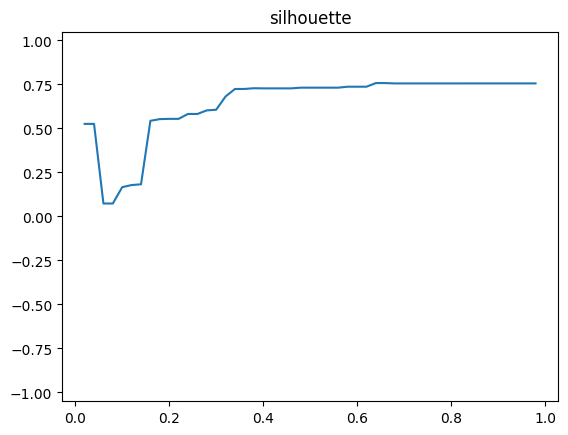

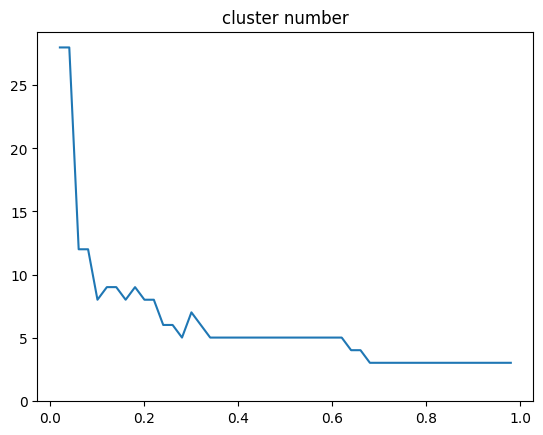

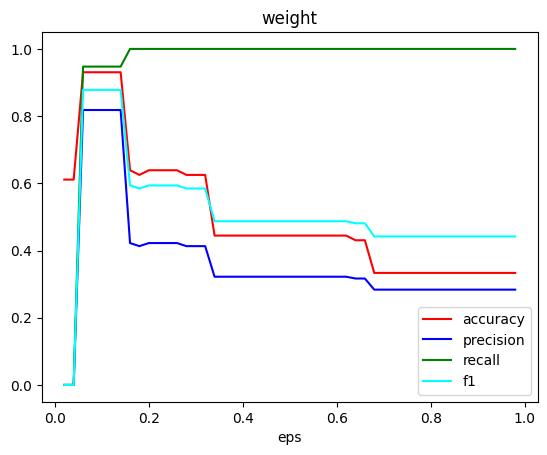

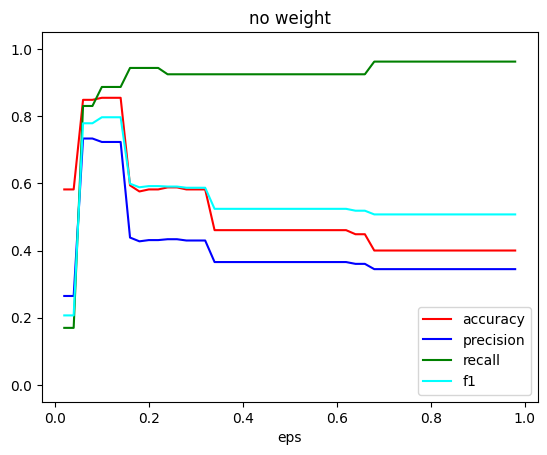

In [15]:
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import os
import json
import glob
import csv
import pprint
import matplotlib.pyplot as plt

save_dir = "./data/_json/0724/clustering_result"
os.makedirs(save_dir, exist_ok=True)
save_file_name = "clustering_data.csv"
with open(f"{save_dir}/{save_file_name}", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id","x", "y", "label"])

notes_file_paths = glob.glob("./data/_json/feature_vector/test/*[[]cnt_move_flip2[]]*.json")
notes_file_paths = [f for f in notes_file_paths if "155" in f]
pprint.pprint(notes_file_paths)
for eps,file_path in enumerate(notes_file_paths):
    data = None
    id = None
    with open(file_path, newline="") as f:
        content = json.load(f)        
        data = preprocessing.StandardScaler().fit_transform(np.array(content["data"]))
        id = content["id"]

    # pprint.pprint(data)
    if data is None or id is None:
        print(f"{file_path} file is not found")
        continue
    # k = 2 * len(data[0]) - 1 # k=2*{dim(dataset)} - 1
    # get_kdist_plot(X=data, k=k)
    # クラスタリング
    range_max = 1
    range_step = 50
    range_min = range_max/range_step
    step = range_max/range_step
    now = range_min
    rng = []
    for i in range(range_step):
        if now < 1:
            rng.append(now)
        now += step
    # print(rng)

    epses = []
    silhouettes = []
    cluster_counts = []
    weight_scores = []
    no_weight_scores = []
    for eps in rng:
        print(f"eps = {eps}")
        epses.append(eps)
        
        clustering_result = DBSCAN(eps=eps, min_samples=3).fit_predict(data)
        clustering_result += 1

        cluster_count = len(set(clustering_result))
        cluster_counts.append(cluster_count)
        print(f"clusters count: {cluster_count}")
        
        silhouette = silhouette_score(data, clustering_result)
        silhouettes.append(silhouette)

        accuracy, precision, recall, f1 = acc_est(clustering_result, False)
        weight_scores.append([accuracy, precision, recall, f1])
        
        accuracy, precision, recall, f1 = est(clustering_result, True)
        no_weight_scores.append([accuracy, precision, recall, f1])
        
    
    def print_scores_max(scores):
        accuracy_max = max(scores[0])
        recall_max = max(scores[1])
        precision_max = max(scores[2])
        recall_max = max(scores[3])
        print(f"{accuracy_max=}\n{recall_max}\n{precision_max}\n{recall_max}")
        
    weight_scores = list(zip(*weight_scores))
    no_weight_scores = list(zip(*no_weight_scores))
    print_scores_max(weight_scores)
    print_scores_max(no_weight_scores)
        
    plt.plot(epses, silhouettes)
    plt.title("silhouette")
    plt.ylim([-1.05, 1.05])
    plt.show()

    plt.plot(epses, cluster_counts)
    plt.title("cluster number")
    plt.ylim(bottom=-0.05)
    plt.show()
    
    colors = ["red", "blue", "green", "cyan"]
    labels = ["accuracy", "precision", "recall", "f1"]
    
    for i in range(len(weight_scores)):
        plt.plot(epses, weight_scores[i], color=colors[i], label=labels[i])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("eps")
    plt.title("weight")
    plt.legend()
    plt.show()
    
    # no_weight_scores
    
    for i in range(len(no_weight_scores)):
        plt.plot(epses, no_weight_scores[i], color=colors[i], label=labels[i])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("eps")
    plt.title("no weight")
    plt.legend()
    plt.show()

    # 0.003250035
    # clustering_result = DBSCAN(eps=0.003250035, min_samples=3).fit_predict(data)
    # clustering_result += 1
    # # 次元削減
    # tsne = TSNE(n_components=2, random_state=0)
    # data_tsne = tsne.fit_transform(data)
    
    # plt.scatter(data_tsne[:,0],data_tsne[:,1], c=clustering_result, cmap="gist_ncar")
    # plt.show()

    # 各区間ごとのデータ
    # for d in zip(data_tsne, clustering_result):
    #     print(d)
    # clustering_data = [[id,float(pos[0]), float(pos[1]), int(l)]for (pos, l) in zip(data_tsne, clustering_result)]

    # with open(f"{save_dir}/{save_file_name}", "a", newline="") as f:
    #     writer = csv.writer(f)
    #     writer.writerows(clustering_data)